## 04 - Supervised Learning

*Train a classifier on known categories, then predict what Unknown contacts might be*

In [22]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
project_root = Path.cwd().parent
df = pd.read_csv(project_root / 'data' / 'features' / 'contact_features.csv')
df.head()

,name,category,total_calls,total_duration,avg_duration,max_duration,pct_business_hours,pct_late_night,avg_hour,first_call,last_call,days_active,is_one_off,calls_per_month,is_active
0,ASBIS Africa,Supplier,9,834,96.0,244,1.000000,0.000000,9.888889,2024-01-26,2024-02-22,27,False,4.736842,False
1,Aaron,Unknown,1,4,4.0,4,1.000000,0.000000,10.000000,2022-05-27,2022-05-27,0,True,1.000000,False
2,Abbas,Unknown,2,78,39.0,73,1.000000,0.000000,10.000000,2022-05-27,2022-05-27,0,False,2.000000,False
3,Abbott,Unknown,1,18,18.0,18,1.000000,0.000000,9.000000,2023-03-22,2023-03-22,0,True,1.000000,False
4,Abdol,Unknown,130,8097,18.0,462,0.615385,0.015385,14.223077,2022-05-27,2022-07-03,37,False,58.208955,False


### Split Known vs Unknown

*We only have 114 labeled contacts to learn from*

In [24]:
known = df[df['category'] != 'Unknown'].copy()
unknown = df[df['category'] == 'Unknown'].copy()

print(f'known contacts: {len(known)}')
print(f'unknown contacts: {len(unknown)}')

known contacts: 114
unknown contacts: 1977


Quite small training set with only 114 samples, but it might be sufficient

### Train a Classifier

*RandomForest on 9 behavioral features*

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

feature_cols = [
    'total_calls', 'total_duration', 'avg_duration', 'max_duration',
    'pct_business_hours', 'pct_late_night', 'avg_hour',
    'days_active', 'calls_per_month'
]

X_known = known[feature_cols]
y_known = known['category']

X_train, X_test, y_train, y_test = train_test_split(
    X_known, y_known, test_size=0.25, random_state=42, stratify=y_known
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate on Test Set

*How well does the model generalize?*

In [26]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

            Family       0.75      0.75      0.75         4
Important Contacts       1.00      0.50      0.67         2
  Service Provider       0.76      1.00      0.87        13
          Supplier       0.86      0.60      0.71        10

          accuracy                           0.79        29
         macro avg       0.84      0.71      0.75        29
      weighted avg       0.81      0.79      0.78        29



The model reaches an accuracy of 79%, very good

### Predict on Unknown Contacts

*Apply the model to 1,977 unknowns*

In [27]:
X_unknown = unknown[feature_cols]
unknown['predicted_category'] = model.predict(X_unknown)

unknown['predicted_category'].value_counts()

predicted_category
Service Provider      958
Supplier              898
Important Contacts     97
Family                 24
Name: count, dtype: int64

We see the model classified only 24 as family members and 97 as important contacts. The vast majority has been classified as business, which is what we inferred from our exploration earlier.

### Our Muffens

*What did the model predict for Duma, Eric, Alli, Park, and Zohra?*

In [28]:
muffens = ['Duma', 'Eric', 'Alli', 'Park', 'Zohra']
unknown[unknown['name'].isin(muffens)][['name', 'predicted_category', 'total_calls', 'pct_business_hours', 'pct_late_night']]

,name,predicted_category,total_calls,pct_business_hours,pct_late_night
32,Alli,Supplier,905,0.659669,0.000000
320,Duma,Family,210,0.304762,0.128571
389,Eric,Family,219,0.310502,0.041096
1246,Park,Supplier,287,0.728223,0.000000
2062,Zohra,Supplier,203,0.689655,0.000000


For Alli, Park, and Zohra, supplier makes sense given their patterns of high business-hours calls and no late-night calls.

For Duma and Eric, family is the closest available category to what we suspect. They have lower business-hours calls, longer calls (1h+), and late-night call activity. Since the model has no "side-boyfriend" category, family seems to be the most reasonable predictor for this model.

### Feature Importance

*Which features drove the predictions?*

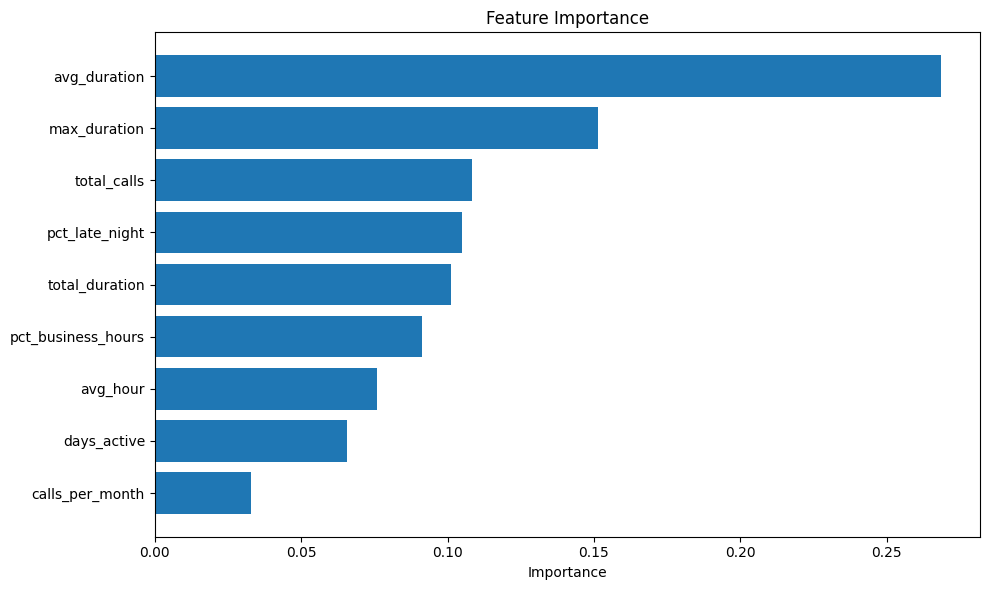

In [31]:
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
  }).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Save Predictions

*Add predicted_category to contact_features.csv*

In [32]:
df['predicted_category'] = df['category']
df.loc[df['category'] == 'Unknown', 'predicted_category'] = unknown['predicted_category'].values
df.to_csv(project_root / 'data' / 'features' / 'contact_features.csv', index=False)


---

## Summary

Trained a RandomForestClassifier on 114 labeled contacts to predict categories for 1,977 unknowns.

| Metric | Value |
|--------|-------|
| Test accuracy | 79% |
| Features used | 9 behavioral features |
| Top feature | avg_duration |

**Predictions breakdown:**
- Service Provider: 958
- Supplier: 898
- Important Contacts: 97
- Family: 24

**Muffens verdict:** Duma and Eric classified as Family - the closest category to what we suspect given their late-night call patterns.